In [198]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# Project Description and Plan

In this project, I am working with a wine dataset that contains various chemical properties of red and white wines. The goal is to apply machine learning to solve two types of problems:

1. **Classification**: Predict whether a wine is red or white.
2. **Regression**: Predict the alcohol percentage of the wine.

To do this, I used three different models:

- **Logistic Regression** to classify red vs. white wine.
- **Support Vector Machine (SVM)** with PCA (Principal Component Analysis) to also classify red vs. white and see how reducing the number of features affects performance.
- **Random Forest Regressor** to predict the alcohol percentage in the wine

My plan was to clean and scale the data, try out different models, tune their hyperparameters using GridSearchCV, and evaluate the performance using the appropriate metrics like accuracy, confusion matrix, classification report, and RMSE, MAE, R-squared (for regression).


# Importing Data

In [130]:
wine = pd.read_csv('wine.csv')
wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### dropping null values

In [131]:
print(wine.isnull().sum())

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [132]:
wine = wine.dropna().reset_index(drop=True)

In [133]:
print(wine.isnull().sum())

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


# Feature Engineering

### adding Sulphates-to-Chlorides Ratio

In [135]:
wine['sulphate_chloride_ratio'] = wine['sulphates'] / wine['chlorides']

In [136]:
wine['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [208]:
wine['alcohol'].unique()

array([ 8.8       ,  9.5       , 10.1       ,  9.9       ,  9.6       ,
       11.        , 12.        ,  9.7       , 10.8       , 12.4       ,
       11.4       , 11.3       , 12.8       , 10.5       ,  9.3       ,
       10.        , 10.4       , 11.6       , 12.3       , 10.2       ,
       11.2       ,  8.6       ,  9.4       ,  9.8       , 11.7       ,
       10.9       ,  8.9       , 10.3       ,  9.1       , 12.6       ,
       10.7       ,  9.        , 12.7       , 10.6       ,  9.2       ,
        8.7       , 11.5       , 11.8       , 12.1       , 11.1       ,
        8.5       , 12.5       , 11.9       , 12.2       , 12.9       ,
       13.9       , 14.        , 13.5       , 13.3       , 13.2       ,
       13.7       , 13.4       , 13.        ,  8.        , 13.1       ,
       13.6       ,  8.4       , 14.2       , 11.94      , 12.89333333,
       11.46666667, 10.98      , 10.03333333, 11.43333333, 10.53333333,
        9.53333333, 10.93333333, 11.36666667, 11.33333333, 11.06

alcohol will work better than the quality for predicting

# Train Test Split & Scaling
#### ensuring we are using the same split whether we are classifying wine type or predicitng alcohol

In [137]:
wine['type_encoded'] = LabelEncoder().fit_transform(wine['type'])

In [138]:
wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphate_chloride_ratio,type_encoded
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,10.000000,1
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,10.000000,1
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,8.800000,1
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,6.896552,1
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,6.896552,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,12.058824,0
6459,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,6.444444,0
6460,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,9.868421,0
6461,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,9.466667,0


In [141]:
features = wine

y_type = wine['type_encoded']     
y_alc = wine['alcohol']          


X_train, X_test, y_train_class, y_test_class = train_test_split(features, y_type, test_size=0.3, random_state=290, stratify=y_type)

_, _, y_train_reg, y_test_reg = train_test_split(features, y_alc, test_size=0.3, random_state=290)


In [142]:
X_train

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphate_chloride_ratio,type_encoded
5147,red,11.5,0.18,0.51,4.00,0.104,4.0,23.0,0.99960,3.28,0.97,10.1,6,9.326923,0
1457,white,6.6,0.25,0.24,1.70,0.048,26.0,124.0,0.99420,3.37,0.60,10.1,6,12.500000,1
1986,white,7.0,0.25,0.56,2.00,0.035,20.0,95.0,0.99180,3.23,0.53,11.0,6,15.142857,1
5977,red,9.1,0.30,0.41,2.00,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7,12.500000,0
5181,red,7.9,0.53,0.24,2.00,0.072,15.0,105.0,0.99600,3.27,0.54,9.4,6,7.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,white,7.7,0.43,1.00,19.95,0.032,42.0,164.0,0.99742,3.29,0.50,12.0,6,15.625000,1
1503,white,7.9,0.28,0.49,7.70,0.045,48.0,195.0,0.99540,3.04,0.55,11.0,6,12.222222,1
6009,red,8.2,0.51,0.24,2.00,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,6,8.101266,0
6264,red,6.4,0.57,0.14,3.90,0.070,27.0,73.0,0.99669,3.32,0.48,9.2,5,6.857143,0


In [143]:
X_train_cl = X_train.drop(columns=['type', 'type_encoded'])
X_train_cl

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphate_chloride_ratio
5147,11.5,0.18,0.51,4.00,0.104,4.0,23.0,0.99960,3.28,0.97,10.1,6,9.326923
1457,6.6,0.25,0.24,1.70,0.048,26.0,124.0,0.99420,3.37,0.60,10.1,6,12.500000
1986,7.0,0.25,0.56,2.00,0.035,20.0,95.0,0.99180,3.23,0.53,11.0,6,15.142857
5977,9.1,0.30,0.41,2.00,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7,12.500000
5181,7.9,0.53,0.24,2.00,0.072,15.0,105.0,0.99600,3.27,0.54,9.4,6,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,7.7,0.43,1.00,19.95,0.032,42.0,164.0,0.99742,3.29,0.50,12.0,6,15.625000
1503,7.9,0.28,0.49,7.70,0.045,48.0,195.0,0.99540,3.04,0.55,11.0,6,12.222222
6009,8.2,0.51,0.24,2.00,0.079,16.0,86.0,0.99764,3.34,0.64,9.5,6,8.101266
6264,6.4,0.57,0.14,3.90,0.070,27.0,73.0,0.99669,3.32,0.48,9.2,5,6.857143


In [144]:
X_test_cl = X_test.drop(columns=['type', 'type_encoded'])
X_test_cl

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphate_chloride_ratio
6302,10.2,0.54,0.37,15.40,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6,3.598131
2926,6.1,0.27,0.25,1.80,0.041,9.0,109.0,0.99290,3.08,0.54,9.0,5,13.170732
3677,7.5,0.24,0.31,13.10,0.050,26.0,180.0,0.99884,3.05,0.53,9.1,6,10.600000
3457,6.1,0.36,0.26,8.15,0.035,14.0,88.0,0.99031,3.06,0.27,13.0,7,7.714286
5133,7.9,0.37,0.23,1.80,0.077,23.0,49.0,0.99630,3.28,0.67,9.3,5,8.701299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,6.8,0.48,0.08,1.80,0.074,40.0,64.0,0.99529,3.12,0.49,9.6,5,6.621622
3542,7.8,0.15,0.34,1.10,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,7,20.571429
4494,5.8,0.31,0.31,7.50,0.052,55.0,230.0,0.99490,3.19,0.46,9.8,5,8.846154
5408,12.9,0.35,0.49,5.80,0.066,5.0,35.0,1.00140,3.20,0.66,12.0,7,10.000000


In [145]:
X_test_reg = X_test.drop(columns=['type', 'alcohol'])
X_test_reg

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,sulphate_chloride_ratio,type_encoded
6302,10.2,0.54,0.37,15.40,0.214,55.0,95.0,1.00369,3.18,0.77,6,3.598131,0
2926,6.1,0.27,0.25,1.80,0.041,9.0,109.0,0.99290,3.08,0.54,5,13.170732,1
3677,7.5,0.24,0.31,13.10,0.050,26.0,180.0,0.99884,3.05,0.53,6,10.600000,1
3457,6.1,0.36,0.26,8.15,0.035,14.0,88.0,0.99031,3.06,0.27,7,7.714286,1
5133,7.9,0.37,0.23,1.80,0.077,23.0,49.0,0.99630,3.28,0.67,5,8.701299,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,6.8,0.48,0.08,1.80,0.074,40.0,64.0,0.99529,3.12,0.49,5,6.621622,0
3542,7.8,0.15,0.34,1.10,0.035,31.0,93.0,0.99096,3.07,0.72,7,20.571429,1
4494,5.8,0.31,0.31,7.50,0.052,55.0,230.0,0.99490,3.19,0.46,5,8.846154,1
5408,12.9,0.35,0.49,5.80,0.066,5.0,35.0,1.00140,3.20,0.66,7,10.000000,0


In [146]:
X_train_reg = X_train.drop(columns=['type', 'alcohol'])
X_train_reg

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,sulphate_chloride_ratio,type_encoded
5147,11.5,0.18,0.51,4.00,0.104,4.0,23.0,0.99960,3.28,0.97,6,9.326923,0
1457,6.6,0.25,0.24,1.70,0.048,26.0,124.0,0.99420,3.37,0.60,6,12.500000,1
1986,7.0,0.25,0.56,2.00,0.035,20.0,95.0,0.99180,3.23,0.53,6,15.142857,1
5977,9.1,0.30,0.41,2.00,0.068,10.0,24.0,0.99523,3.27,0.85,7,12.500000,0
5181,7.9,0.53,0.24,2.00,0.072,15.0,105.0,0.99600,3.27,0.54,6,7.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,7.7,0.43,1.00,19.95,0.032,42.0,164.0,0.99742,3.29,0.50,6,15.625000,1
1503,7.9,0.28,0.49,7.70,0.045,48.0,195.0,0.99540,3.04,0.55,6,12.222222,1
6009,8.2,0.51,0.24,2.00,0.079,16.0,86.0,0.99764,3.34,0.64,6,8.101266,0
6264,6.4,0.57,0.14,3.90,0.070,27.0,73.0,0.99669,3.32,0.48,5,6.857143,0


In [149]:
y_train_reg

3529     9.9
524     11.4
5360    10.6
3035    10.4
3169    10.9
        ... 
1709    11.1
2845    12.3
1320    12.2
1190    10.8
5757    12.1
Name: alcohol, Length: 4524, dtype: float64

In [68]:
# do not need to scale data for regression Random Forest, just using original reg dataframes
# only scaling for the classification models I am doing
scaler = StandardScaler()
X_train_cl_scaled = scaler.fit_transform(X_train_cl)
X_test_cl_scaled = scaler.transform(X_test_cl)

# The Models

## Logistic Regression

In [115]:
def grid_search_log_reg(X_train, X_test, y_train, y_test, param_list):
    best_model = {}
    label_names = ['red', 'white']
    for name, model, param_grid in param_list:
        print(f"{name} with GridSearchCV")
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train, y_train)
        best_model[name] = grid.best_estimator_
        
        print(f"Best parameters for {name}: {grid.best_params_}")
        print(f"Best CV accuracy for {name}: {grid.best_score_}")
        
        y_prob = best_model[name].predict_proba(X_test)[:, 1]  
        auc = roc_auc_score(y_test, y_prob)
        print("\nAUC-ROC Score:", auc)

        
        y_pred = grid.predict(X_test)
        print(f"\n {name} Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_names), "\n")
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(cmap='Reds')
        plt.title(f"{name} Confusion Matrix")
        plt.show()

        
    return best_model

Logistic Regression with GridSearchCV
Best parameters for Logistic Regression: {'C': 1.0}
Best CV accuracy for Logistic Regression: 0.996020877132939

AUC-ROC Score: 0.9907096360319493

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

         red       0.99      0.98      0.98       478
       white       0.99      1.00      0.99      1461

    accuracy                           0.99      1939
   macro avg       0.99      0.99      0.99      1939
weighted avg       0.99      0.99      0.99      1939
 



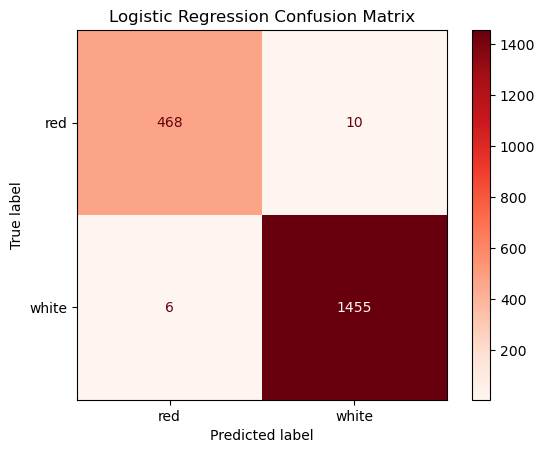

In [116]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

param_grid_log_reg = {
    'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05]

}

param_list = [
    ("Logistic Regression", log_reg, param_grid_log_reg)
]


log_reg_results = grid_search_log_reg(X_train_cl_scaled, X_test_cl_scaled, y_train_class, y_test_class, param_list)


## SVM w/ PCA

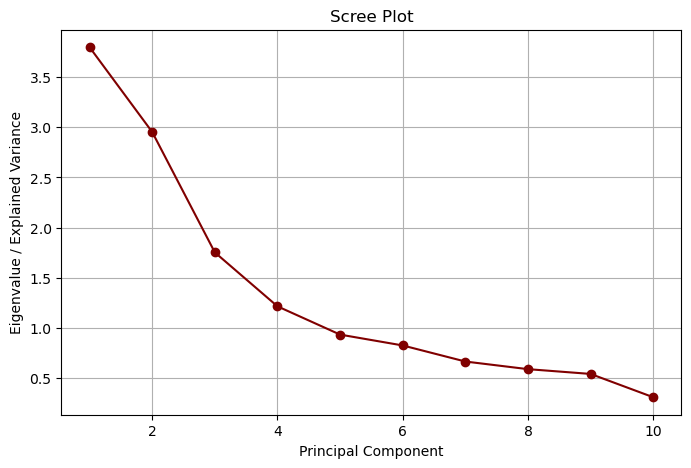

In [200]:
pca = PCA(n_components=10)
pca.fit(X_train_cl_scaled)
explained_variance = pca.explained_variance_


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', color='maroon')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue / Explained Variance')
plt.grid(True)
plt.show()

wanted to see some other visualization to help choose how many components to try

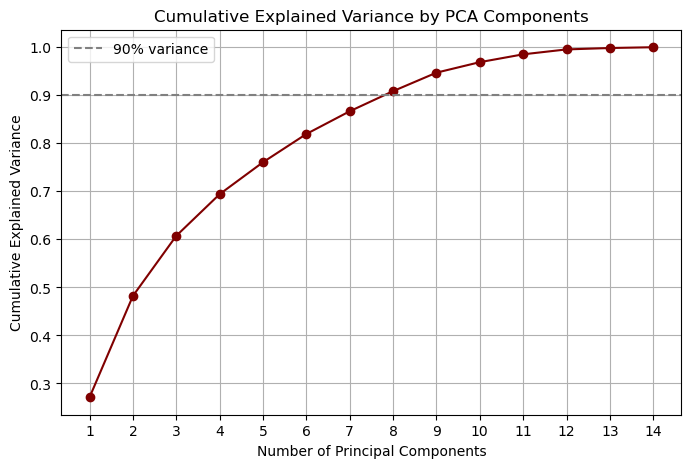

In [213]:
pca = PCA()
pca.fit(X_train_cl_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='maroon')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.axhline(y=0.90, color='gray', linestyle='--', label='90% variance')
plt.legend()
plt.show()


#### Doing GridSearch with 4 and 8 compnonents


***** PCA with 4 Components *****

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best CV Accuracy: 0.9883
Test Accuracy: 0.985

Classification Report:
              precision    recall  f1-score   support

         red       0.97      0.97      0.97       478
       white       0.99      0.99      0.99      1461

    accuracy                           0.99      1939
   macro avg       0.98      0.98      0.98      1939
weighted avg       0.99      0.99      0.99      1939



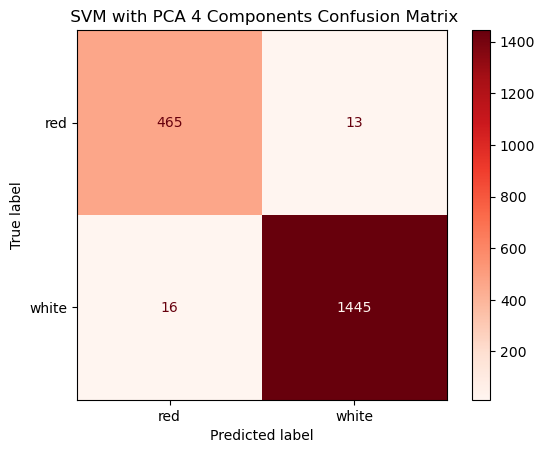


***** PCA with 8 Components *****

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best CV Accuracy: 0.9958
Test Accuracy: 0.9923

Classification Report:
              precision    recall  f1-score   support

         red       0.99      0.98      0.98       478
       white       0.99      1.00      0.99      1461

    accuracy                           0.99      1939
   macro avg       0.99      0.99      0.99      1939
weighted avg       0.99      0.99      0.99      1939



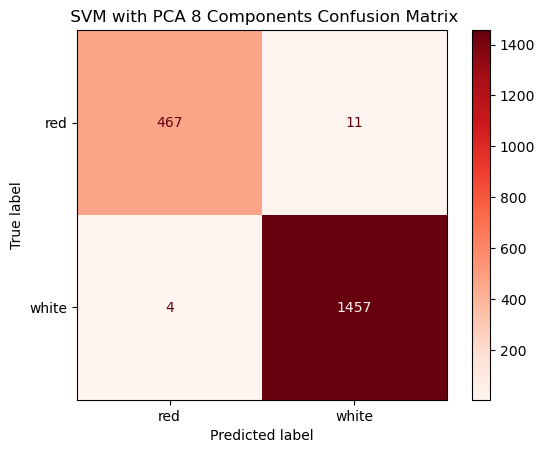

In [206]:
components_list = [4, 8]

param_grid = {
    'C': [0.1,0.5, 1, 1.1, 1.5, 2, 5],
    'kernel': ['linear', 'rbf', 'poly']
}


for n in components_list:
    print(f"\n***** PCA with {n} Components *****\n")
    

    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_cl_scaled)
    X_test_pca = pca.transform(X_test_cl_scaled)


    svm = SVC()
    grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train_pca, y_train_class)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_pca)


    print("Best Parameters:", grid.best_params_)
    print("Best CV Accuracy:", round(grid.best_score_, 4))
    print("Test Accuracy:", round(best_model.score(X_test_pca, y_test_class), 4))

    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred, target_names=['red', 'white']))

    cm = confusion_matrix(y_test_class, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['red', 'white'])
    disp.plot(cmap='Reds')
    plt.title(f" SVM with PCA {n} Components Confusion Matrix")
    plt.show()


## Random Forest

In [167]:
def grid_search_rf(X_train, X_test, y_train, y_test, param_list):
    best_models = {}
    
    for name, model, param_grid in param_list:
        print(f"Training {name} with GridSearchCV")
        
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        
        print(f"Best parameters for {name}: {grid.best_params_}")

        
    return best_models

In [168]:
rf = RandomForestRegressor()
rf_params = {"max_depth": [2,3,4,5,10],
              "min_samples_split": [2, 5, 10],
              'n_estimators': [50, 100, 200]}

param_list = [
    ("Random Forest", rf, rf_params)
]
rf_results = grid_search_rf(X_train_reg, X_test_reg, y_train_reg, y_test_reg, param_list)

Training Random Forest with GridSearchCV
Best parameters for Random Forest: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [210]:
y_pred_reg = rf_results['Random Forest'].predict(X_test_reg)

rmse = np.sqrt(mse(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = rf_results['Random Forest'].score(X_test_reg, y_test_reg)

print('***** Random Forest Regression Metrics *****\n')
print('RMSE:' ,rmse, '\nMean Absolute Error:', mae, '\nR-squared', r2)

***** Random Forest Regression Metrics *****

RMSE: 1.190825863795275 
Mean Absolute Error: 0.9975649499344722 
R-squared -0.0009283106067847768


In [175]:
rf_results

{'Random Forest': RandomForestRegressor(max_depth=3, min_samples_leaf=2, n_estimators=50)}

In [212]:
rf_model = rf_results['Random Forest']
importances = rf_model.feature_importances_
feature_names = X_train_reg.columns 
importance_df = pd.DataFrame({'Feature': feature_names,'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,sulphate_chloride_ratio,0.255641
1,pH,0.148994
2,total sulfur dioxide,0.126935
3,volatile acidity,0.089401
4,chlorides,0.072472
5,sulphates,0.060680
6,free sulfur dioxide,0.059683
7,citric acid,0.052528
8,fixed acidity,0.048356
9,density,0.036843


In [196]:
alcohol_corr = wine.corr(numeric_only=True)['alcohol'].drop('alcohol').sort_values(ascending=False)

alcohol_corr_df = alcohol_corr.reset_index()
alcohol_corr_df.columns = ['Feature', 'Correlation with Alcohol']
alcohol_corr_df

,Feature,Correlation with Alcohol
0,quality,0.444637
1,sulphate_chloride_ratio,0.394653
2,pH,0.120473
3,type_encoded,0.035095
4,sulphates,-0.004116
5,citric acid,-0.010056
6,volatile acidity,-0.039528
7,fixed acidity,-0.096190
8,free sulfur dioxide,-0.179477
9,chlorides,-0.257664


# Discussion of Results

### Logistic Regression

The logistic regression model did a great job predicting whether the wine was red or white. It had a test accuracy of 99%, and the AUC-ROC score was also very high at 0.99. The confusion matrix shows that only 16 wines were misclassified out of 1,939, which means the model was very reliable. This model is also not costly, which makes it even better.

### SVM with PCA (4 Components)

The SVM model with 4 PCA components also worked well, with a test accuracy of 98.5%. It didn't perform quite as well as logistic regression or the SVM model with 8 components, and it misclassified 29 wines. This might be because using only 4 components removed too much information from the data. The model used a linear kernel with a small C value, which probably made it less flexible. Still, 98.5% accuracy is very strong, and this model shows that even with reduced features, we can still get high performance.

### SVM with PCA (8 Components)

When I used 8 PCA components instead, the SVM model did slightly better. It had a test accuracy of 99.2%, which is basically the same as logistic regression. It only misclassified 15 wines, and used an RBF kernel. Using more components clearly helped the model do better than the version with 4, but again, both versions still did very well overall.

### Random Forest Regressor

The random forest model was used to predict the alcohol percentage of each wine. This model didn’t perform well. The R-squared value was basically zero (actually slightly negative), which means it didn’t do better than just guessing the average alcohol value. The RMSE and MAE were both close to 1, which is a large error considering that alcohol percentages in the dataset only range from about 8% to 14%.

One likely reason for this poor performance is that many of the features in the dataset don’t have a strong relationship with alcohol content. The correlation analysis showed that density had the strongest relationship with alcohol (a strong negative correlation), but the random forest model didn’t rely on it much. Instead, it focused more on features like sulphate_chloride_ratio, pH, and total sulfur dioxide, which had much weaker correlations with alcohol. This may have limited the model's ability to make accurate predictions.

Before trying alcohol as a target, I also tried using wine quality as the regression target, but it didn't work well either. I also tried treating quality as a classification problem, but there wasn’t enough variety in the values to make that work either. Most wines were clustered around a few quality scores, which made it hard for the model to learn anything useful.

### Model Comparison

- Logistic regression and the SVM model with 8 components both did great at classifying wine as red or white.
- The SVM model with 4 components also did very well, just slightly below the others, showing that even with fewer features, we can still get high accuracy.
- The random forest model didn’t do well at predicting alcohol or quality. Most of the features didn’t have a strong relationship with alcohol, and the data for quality wasn’t varied enough for the model to learn from.

### Conclusion

Overall, logistic regression and SVM (especially with more components) are both strong models for classifying wine as red or white. PCA helped reduce the number of features while still keeping high performance. On the other hand, random forest didn’t work well for regression on predicting alcohol or quality, so we would probably need better features, and/or more data.